# **Fake Image Generation using Stylegan-ada**

In [31]:
# Run this for Google CoLab (use TensorFlow 1.x)
%tensorflow_version 1.x
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [32]:
!git clone https://github.com/NVlabs/stylegan2-ada.git

fatal: destination path 'stylegan2-ada' already exists and is not an empty directory.


In [ ]:
!ls /content/stylegan2-ada/

In [33]:
import sys
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt

sys.path.insert(0, "/content/stylegan2-ada")

import dnnlib
import dnnlib.tflib as tflib

def seed2vec(Gs, seed):
  rnd = np.random.RandomState(seed)
  return rnd.randn(1, *Gs.input_shape[1:])

def init_random_state(Gs, seed):
  rnd = np.random.RandomState(seed) 
  noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
  tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]

def display_image(image):
  plt.axis('off')
  plt.imshow(image)
  plt.show()

def generate_image(Gs, z, truncation_psi):
    # Render images for dlatents initialized from random seeds.
    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    label = np.zeros([1] + Gs.input_shapes[1][1:])
    images = Gs.run(z, label, **Gs_kwargs) # [minibatch, height, width, channel]
    return images[0]

In [34]:
import IPython.display

URL="https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"
#URL="https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ"
#URL = "https://github.com/jeffheaton/pretrained-gan-fish/releases/download/1.0.0/fish-gan-2020-12-09.pkl"
#URL = "https://github.com/jeffheaton/pretrained-merry-gan-mas/releases/download/v1/christmas-gan-2020-12-03.pkl"
#URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"
tflib.init_tf()
print('Loading networks from "%s"...' % URL)
with dnnlib.util.open_url(URL) as fp:
    _G, _D, Gs = pickle.load(fp)

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"...


Seed 1


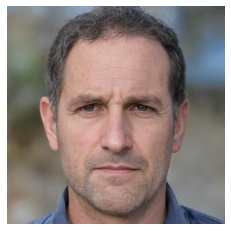

Seed 2


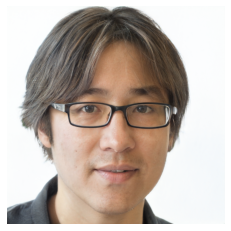

Seed 3


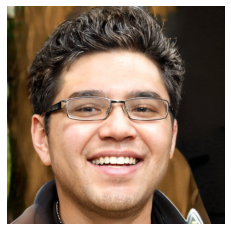

Seed 4


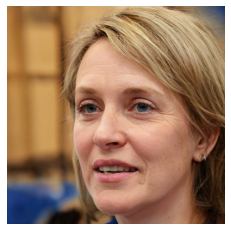

Seed 5


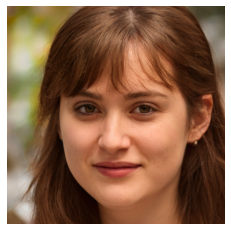

Seed 6


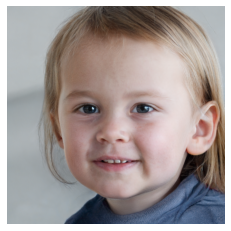

Seed 7


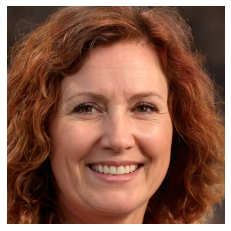

Seed 8


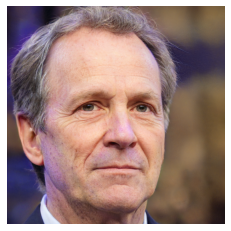

Seed 9


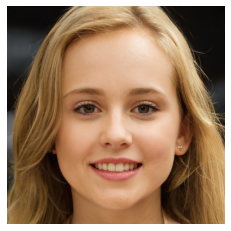

In [36]:
# Choose your own starting and ending seed.
SEED_FROM = 1
SEED_TO = 10

# Generate the images for the seeds.
for i in range(SEED_FROM, SEED_TO):
  print(f"Seed {i}")
  init_random_state(Gs, 10)
  z = seed2vec(Gs, i)
  img = generate_image(Gs, z, 0.7)
  display_image(img)

## **Examining the Latent Vector**
Figure 7.LVEC shows the effects of transforming the latent vector between two images. This transformation is accomplished by moving one 512-value latent vector slowly to the other 512 vector. Images that have similar latent vectors will appear similarly to each other. A high-dimension point between two latent vectos will appear similar to both of the two endpoint latent vectors.

In [37]:
def expand_seed(seeds, vector_size):
  result = []

  for seed in seeds:
    rnd = np.random.RandomState(seed)
    result.append( rnd.randn(1, vector_size) ) 
  return result

#URL = "https://github.com/jeffheaton/pretrained-gan-fish/releases/download/1.0.0/fish-gan-2020-12-09.pkl"
#URL = "https://github.com/jeffheaton/pretrained-merry-gan-mas/releases/download/v1/christmas-gan-2020-12-03.pkl"
URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"
tflib.init_tf()
print('Loading networks from "%s"...' % URL)
with dnnlib.util.open_url(URL) as fp:
    _G, _D, Gs = pickle.load(fp)

vector_size = Gs.input_shape[1:][0]
# range(8192,8300)
seeds = expand_seed( [8192+1,8192+9], vector_size)
#generate_images(Gs, seeds,truncation_psi=0.5)
print(seeds[0].shape)

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"...
(1, 512)


## **Transistion Video Generation**

In [ ]:
# Choose your seeds to morph through and the number of steps to take to get to each.

SEEDS = [1000,1004,1001]
STEPS = 100

# Remove any prior results
!rm /content/results/* 

from tqdm.notebook import tqdm

os.makedirs("./results/", exist_ok=True)

# Generate the images for the video.
idx = 0
for i in range(len(SEEDS)-1):
  v1 = seed2vec(Gs, SEEDS[i])
  v2 = seed2vec(Gs, SEEDS[i+1])

  diff = v2 - v1
  step = diff / STEPS
  current = v1.copy()

  for j in tqdm(range(STEPS), desc=f"Seed {SEEDS[i]}"):
    current = current + step
    init_random_state(Gs, 10)
    img = generate_image(Gs, current, 1.0)
    PIL.Image.fromarray(img, 'RGB').save(f'./results/frame-{idx}.png')
    idx+=1
 
# Link the images into a video.
!ffmpeg -r 30 -i /content/results/frame-%d.png -vcodec mpeg4 -y movie.mp4

In [40]:
from google.colab import files
files.download('movie.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>